In [2]:
from HeaderP import *
import Astraea
from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice
import random

In [8]:
def Calcdv_bin(df,bin_names,bin_sizes):
    Nstars=len(df) # how many stars to calculate
    bin_len=len(bin_names) # how many bins to calculate
    
    # initialize velocity dispersion
    df['dv']=np.zeros(Nstars)
    df['NoStar']=np.zeros(Nstars)
    
    for i in range(Nstars):
        update_progress(i/Nstars)
        
        star=df.iloc[i]
        
        ##### get the mask #####
        para = star[bin_names[0]]
        mask = (abs(df[bin_names[0]]-para) <= bin_sizes[0]/2.)
        for j in range(1,bin_len):
            para = star[bin_names[j]]
            mask = mask & (abs(df[bin_names[j]]-para) <= bin_sizes[j]/2.)
        ##### get the mask #####
        
        # get the clossest stadrs v_b
        NNstars=df.loc[mask]
    
        MAD=sum(abs(NNstars['v_b']-np.median(NNstars['v_b'])))/float(len(NNstars))

        df['dv'].iloc[i]=1.5*MAD
        df['NoStar'].iloc[i]=len(NNstars)

def Calcdv(df,f1,f2,NN):
    Nstars=len(df)
    X_nn = StandardScaler().fit_transform(df[[f1,f2]])
    df[f1+'_norm'],df[f2+'_norm'] = X_nn[:,0], X_nn[:,1]
    
    # initialize velocity dispersion
    df['dv_MAD']=np.zeros(Nstars)
    df['dv_STD']=np.zeros(Nstars)
    for i in range(Nstars):
        update_progress(i/Nstars)
        teff = df.iloc[i][f1+'_norm']
        Prot = df.iloc[i][f2+'_norm']
        df['dist'] = np.sqrt(np.power(df[f1+'_norm']-teff,2.)+np.power(df[f2+'_norm']-Prot,2.))
        
        # get the clossest stadrs v_b
        NNstars=df.loc[df.sort_values(by=['dist']).iloc[0:NN].index]
    
        MAD=sum(abs(NNstars['v_b']-np.median(NNstars['v_b'])))/float(len(NNstars))

        df['dv_MAD'].iloc[i]=1.5*MAD
        df['dv_STD'].iloc[i]=np.std(NNstars['v_b'])

In [9]:
mpf = 'aviary/data/metal_poor_avr.csv'
mrf = 'aviary/data/metal_rich_avr.csv'
af = 'aviary/data/all_stars_avr.csv'
def get_avr_coefficients():
    """
    Fit the parameters of the AVR using data from Yu & Liu:
    https://arxiv.org/pdf/1712.03965.pdf
    Fit to the relationship between log(sigma_z) and age.
    Returns:
        p_mp (array): coefficients [slope, intercept] for straight line fit to
            metal poor stars.
        p_mr (array): coefficients [slope, intercept] for straight line fit to
            metal rich stars.
        p_a (array): coefficients [slope, intercept] for straight line fit to
            all stars.
    """
    mp = pd.read_csv(mpf)
    mr = pd.read_csv(mrf)
    a = pd.read_csv(af)

    p_mp = np.polyfit(np.log(mp.sigma_z_kms), np.log(mp.Age_Gyr), 1)
    p_mr = np.polyfit(np.log(mr.sigma_z_kms), np.log(mr.Age_Gyr), 1)
    p_a = np.polyfit(np.log(a.sigma_z_kms), np.log(a.Age_Gyr), 1)

    return p_mp, p_mr, p_a

def v_to_age(v, coeffs):
    """
    Convert z velocity dispersion [km/s] to age [Gyr]
    Args:
        v (array): Z Velocity dispersion [km/s].
        coeffs (array): coefficients for straight line fit. [intercept, slope]
    Returns:
        age (array): age in Gyr.
    """
    b, a = coeffs
    logt = np.polyval(coeffs, np.log(v))
    return np.exp(logt)

In [124]:
dfRvar=pd.read_pickle('NewData/RvarVP_MS_150_w015_bin.pkl')
dfProt=pd.read_pickle('NewData/ProtVP_MS_150_w015_bin.pkl')

df=pd.merge(dfRvar[['KID','Rvar']],dfProt[['KID','Prot','Prot_log','teff_calc','v_b','Mass','source_id']],
            left_on='KID',right_on='KID',how='inner')
df['Rvar_log']=np.log10(df['Rvar'])
print(len(df))
#testbins=['teff_calc','Prot_log','Rvar_log','Mass']
testbins=['teff_calc','Prot_log','Rvar_log']
testsize=np.std(df[testbins])
df.dropna(subset=np.append(testbins,'v_b'))
df

20235


,KID,Rvar,Prot,Prot_log,teff_calc,v_b,Mass,source_id,Rvar_log
0,892834,15161.266923,13.765,1.138776,4856.095860,-0.966857,0.7806,2.050232e+18,4.180735
1,892882,8954.119682,22.292,1.348149,5161.614380,-8.869635,0.8576,2.050236e+18,3.952023
2,893033,7689.008117,26.999,1.431348,4669.776075,-47.684635,0.7572,2.050233e+18,3.885870
3,893286,5515.944958,28.211,1.450418,5306.722320,4.320261,0.8995,2.050238e+18,3.741620
4,893383,3817.957640,21.598,1.334414,5667.561801,-19.842956,0.9493,2.050237e+18,3.581831
...,...,...,...,...,...,...,...,...,...
20230,12884971,15717.554092,25.991,1.414823,4202.555977,-29.351048,0.6146,2.139322e+18,4.196385
20231,12934465,3263.875842,34.910,1.542950,4728.426509,8.648168,0.7591,2.139335e+18,3.513734
20232,12934488,604.498386,51.754,1.713944,5800.269677,-46.627427,1.0281,2.139335e+18,2.781395
20233,12934525,4037.582874,25.101,1.399691,5267.359329,-1.165221,0.9062,2.139335e+18,3.606121


['teff_calc', 'Prot_log', 'Rvar_log']
[1.39636847e+02 5.89215745e-02 7.70107890e-02]


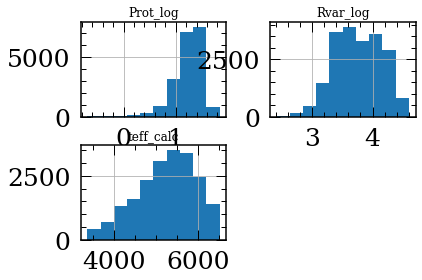

In [125]:
print(testbins)
df[testbins].hist()
print(np.std(df[testbins]).values/5)

In [126]:
Calcdv_bin(df,testbins,testsize)

Progress: [####################] 100.0%


/Users/lucy/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/lucy/anaconda3/lib/python3.7/site-packages/numpy/lib/polynomial.py:675: RuntimeWarning: invalid value encountered in multiply
  y = y * x + p[i]


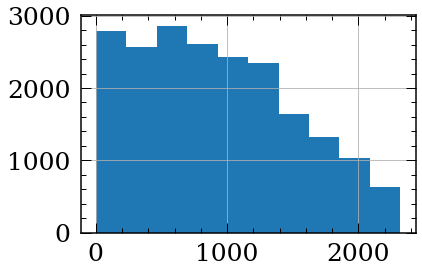

In [127]:
df['NoStar'].hist()

p_mp, p_mr, p_a = get_avr_coefficients()
df['age']=v_to_age(df['dv'],p_mp)

Pleiades 0.12
Praesepe 0.67
Hyades 0.73
NGC_6811 1.0
NGC_752 1.4
NGC_6819 2.5
Ruprecht_147 2.7


Text(0, 0.5, 'Prot [days]')

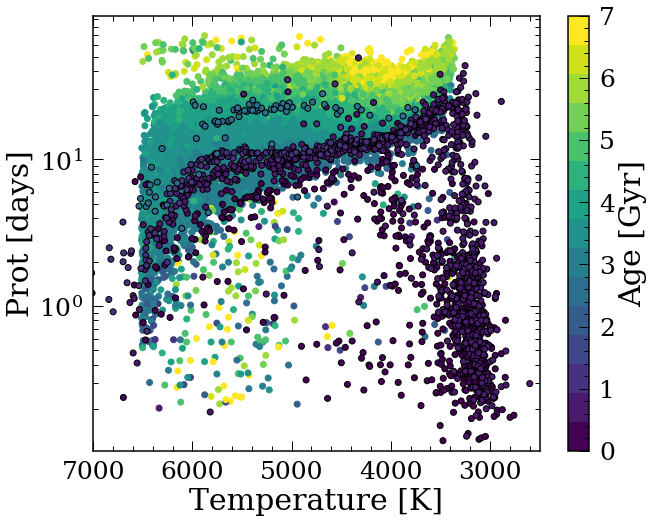

In [128]:
Clusters=pd.read_pickle('OpenClusters/clusters.pkl')

plt.figure(figsize=(10,8))
cm = plt.cm.get_cmap('viridis',15)
plt.scatter(df['teff_calc'],df['Prot'],c=df['age'],cmap=cm,vmin=0,vmax=7)
for name in Clusters.CLUSTER.unique():
    dfProt_cluster_single=Clusters.loc[Clusters['CLUSTER']==name]
    print(name,dfProt_cluster_single['AGE'].iloc[0])
    plt.scatter(dfProt_cluster_single['TEFF'],dfProt_cluster_single['PROT'],
                c=dfProt_cluster_single['AGE'],cmap=cm,vmin=0,vmax=7,edgecolor='k')
    
cb=plt.colorbar()
plt.xlim([2500,7000])
plt.yscale('log')
cb.set_label('Age [Gyr]')
plt.gca().invert_xaxis()
plt.xlabel('Temperature [K]')
plt.ylabel('Prot [days]')


Text(0, 0.5, 'Prot [days]')

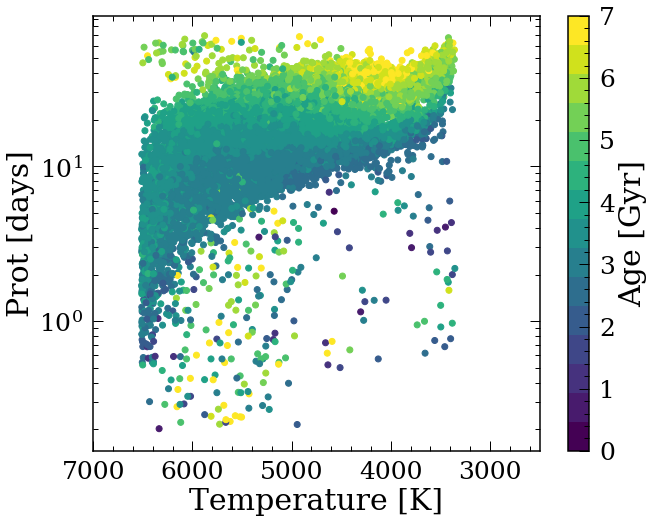

In [129]:

plt.figure(figsize=(10,8))
cm = plt.cm.get_cmap('viridis',15)
plt.scatter(df['teff_calc'],df['Prot'],c=df['age'],cmap=cm,vmin=0,vmax=7)
cb=plt.colorbar()
plt.xlim([2500,7000])
plt.yscale('log')
cb.set_label('Age [Gyr]')
plt.gca().invert_xaxis()
plt.xlabel('Temperature [K]')
plt.ylabel('Prot [days]')

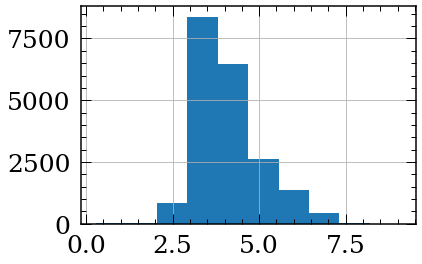

In [130]:
df['age'].hist()

(0, 5)

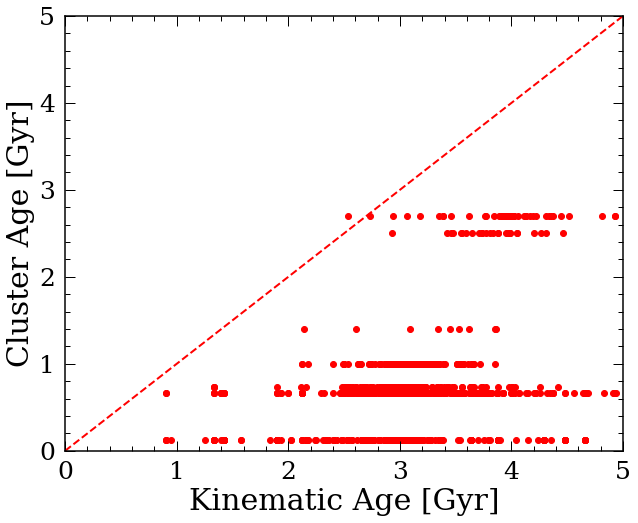

In [131]:
df_CLUSTERS=pd.merge(Clusters,df[np.append(testbins,['KID','v_b','age'])],left_on='KID',right_on='KID',how='inner')

plt.figure(figsize=(10,8))
plt.scatter(df_CLUSTERS['age'],df_CLUSTERS['AGE'],c='r',cmap=cm)
plt.plot([0,5],[0,5],'r--')

#plt.ylim([0,50000])
plt.xlabel('Kinematic Age [Gyr]')
plt.ylabel('Cluster Age [Gyr]')
plt.xlim([0,5])
plt.ylim([0,5])

In [132]:
df_CLUSTERS=df_CLUSTERS.dropna(subset=['age'])
df_CLUSTERS

,CLUSTER,DR2NAME,DR2_NUM,ID,ID_SOURCE,RA,DEC,BP_RP,GMAG,AGE,...,PROT_REF,TEFF,MASS,BENCH,KID,teff_calc,Prot_log,Rvar_log,v_b,age
0,Pleiades,Gaia DR2 67656665605333888,6.765667e+16,210991540.0,EPIC,52.957790,22.839998,2.9081,16.6659,0.12,...,Rebull et al. (2016),3241.33,0.232464,0,10448377.0,3354.363675,0.340444,4.380793,28.376418,3.637226
1,Pleiades,Gaia DR2 67878663874731136,6.787866e+16,211016313.0,EPIC,53.032861,23.232432,2.8637,16.1345,0.12,...,Rebull et al. (2016),3265.81,0.245431,0,10448377.0,3354.363675,0.340444,4.380793,28.376418,3.637226
2,Pleiades,Gaia DR2 67899520235887616,6.789952e+16,211029135.0,EPIC,53.157631,23.432923,3.1979,17.2195,0.12,...,Rebull et al. (2016),3097.46,0.175724,0,10448377.0,3354.363675,0.340444,4.380793,28.376418,3.637226
3,Pleiades,Gaia DR2 67998201404864896,6.799820e+16,211037397.0,EPIC,53.176364,23.566567,3.1000,16.6720,0.12,...,Rebull et al. (2016),3144.56,0.189588,0,10448377.0,3354.363675,0.340444,4.380793,28.376418,3.637226
4,Pleiades,Gaia DR2 67667935599570432,6.766794e+16,210997742.0,EPIC,53.457583,22.938671,2.9765,17.2379,0.12,...,Rebull et al. (2016),3205.27,0.213421,0,10448377.0,3354.363675,0.340444,4.380793,28.376418,3.637226
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1769,Ruprecht_147,Gaia DR2 4084617394338908672,4.084617e+18,218986703.0,EPIC,288.978836,-17.770926,2.1041,15.8266,2.70,...,Curtis et al. (2020),3827.89,0.583471,1,12735805.0,3829.807721,1.336340,3.955974,16.886975,4.310415
1770,Ruprecht_147,Gaia DR2 4084650276604851200,4.084650e+18,218984438.0,EPIC,289.498307,-17.775669,1.4662,14.0045,2.70,...,Curtis et al. (2020),4554.71,0.742648,1,9289069.0,4554.067339,1.344864,3.930735,6.482358,4.355152
1771,Ruprecht_147,Gaia DR2 4087709049240821632,4.087709e+18,219234791.0,EPIC,288.040221,-17.227340,1.3189,13.9896,2.70,...,Curtis et al. (2020),4836.90,0.805752,1,9845007.0,4836.802308,1.365694,4.008517,-23.548778,4.127137
1772,Ruprecht_147,Gaia DR2 4184140406570650496,4.184140e+18,219721519.0,EPIC,289.073212,-16.005055,1.1994,13.0800,2.70,...,Curtis et al. (2020),5107.81,0.867500,1,8674406.0,5108.600951,1.347896,4.013602,-14.726567,3.906925


# Train on cluster data

In [133]:
regr, regr_outs = Astraea.RFregressor(df_CLUSTERS, np.append(testbins,'age'),
                                      target_var='AGE', target_var_err='AGE', n_estimators=3)

Simpliest example:
 regr,regr_outs = RFregressor(df,testF)

Fraction of data used to train: 0.8
# of Features attempt to train: 4
Features attempt to train: ['teff_calc' 'Prot_log' 'Rvar_log' 'age']
1766 stars in dataframe!
1766 total stars used for RF!
1412 training stars!
Finished training! Making predictions!
Finished predicting! Calculating statistics!
Median Relative Error is: 0.39744998980877644
Average chi^2 is: 0.7210173125049166
Finished!


In [134]:
regr_outs

importance    [0.32911727964942056, 0.44306003878085826, 0.0...
actrualF                   [teff_calc, Prot_log, Rvar_log, age]
ID_train      [10448377.0, 10448377.0, 10448377.0, 6696016.0...
ID_test       [10448377.0, 10448377.0, 10448377.0, 10448377....
prediction    [0.4037085068281198, 0.4037085068281198, 0.403...
ave_chi2                                               0.721017
MRE                                                     0.39745
X_test        [[3354.3636750885476, 0.34044411484011833, 4.3...
y_test        [0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.1...
X_train       [[3354.3636750885476, 0.34044411484011833, 4.3...
y_train       [0.67, 0.67, 0.12, 0.67, 0.12, 1.0, 0.12, 0.12...
dtype: object

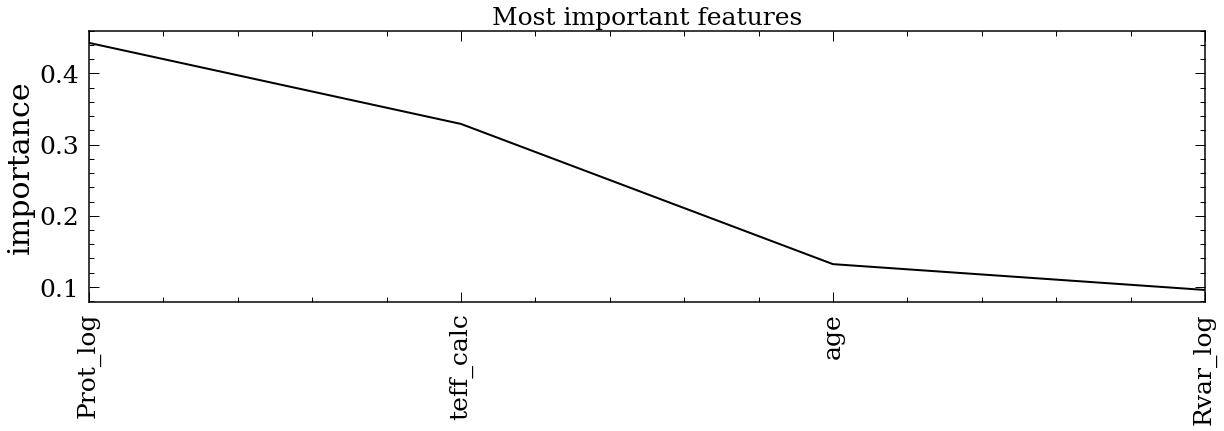

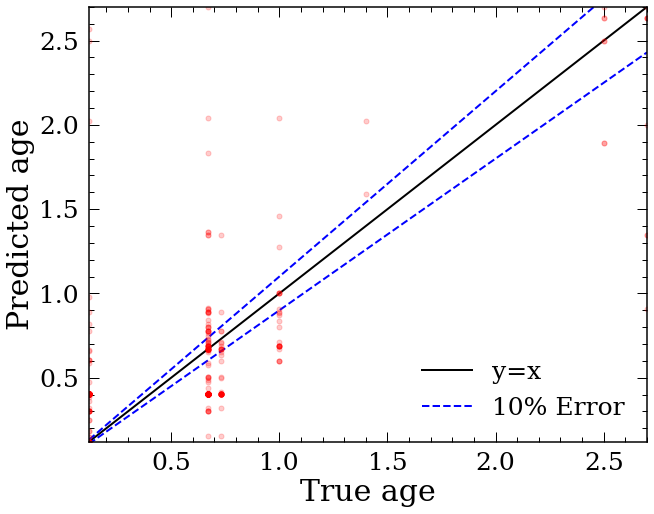

In [135]:
Astraea.plot_result(regr_outs['actrualF'], regr_outs['importance'], regr_outs['prediction'],
                    regr_outs['y_test'], labelName='age', MS=10)

# Astroseismic stars

In [136]:
ASstars=pd.read_table('/Users/lucy/Desktop/KeplerAges/ASage.webarchive',delimiter=',',skiprows=2)
ASstars=ASstars.dropna(subset=['KIC'])
ASstars

Clusters_cm=pd.merge(ASstars,df,left_on='KIC',right_on='KID',how='inner')
Clusters_cm



,Pipe,KIC,Mass_x,Rad,log(g),Age,Lum,rho,Dist,Xini,...,Prot,Prot_log,teff_calc,v_b,Mass_y,source_id,Rvar_log,dv,NoStar,age
0,AST,3735871.0,1.1112,1.1014,4.3995,1.8414,1.5230,1.171100,124.05,0.7070,...,11.172,1.048131,6070.034302,3.505467,1.2242,2.099574e+18,2.986694,14.921976,181.0,3.875052
1,BASTA,3735871.0,1.0890,1.0957,4.3956,2.3457,1.5040,1.169009,123.40,0.7080,...,11.172,1.048131,6070.034302,3.505467,1.2242,2.099574e+18,2.986694,14.921976,181.0,3.875052
2,C2kSMO,3735871.0,1.0757,1.0858,4.3979,1.4544,1.4300,1.183600,122.29,0.6920,...,11.172,1.048131,6070.034302,3.505467,1.2242,2.099574e+18,2.986694,14.921976,181.0,3.875052
3,GOE,3735871.0,1.1057,1.0978,4.4004,1.6456,1.5186,1.177094,123.64,0.7105,...,11.172,1.048131,6070.034302,3.505467,1.2242,2.099574e+18,2.986694,14.921976,181.0,3.875052
4,V&amp;A,3735871.0,1.1050,1.0990,4.3992,1.7710,1.4540,1.172499,123.77,0.7090,...,11.172,1.048131,6070.034302,3.505467,1.2242,2.099574e+18,2.986694,14.921976,181.0,3.875052
5,YMCM,3735871.0,1.1316,1.1084,4.4017,1.9465,0.1854,1.169900,124.84,0.7210,...,11.172,1.048131,6070.034302,3.505467,1.2242,2.099574e+18,2.986694,14.921976,181.0,3.875052
6,AST,9139151.0,1.1483,1.1499,4.3763,2.4324,1.8510,1.063400,101.18,0.7020,...,12.025,1.080085,6053.960666,-0.036908,1.0801,2.106822e+18,2.877817,15.608490,131.0,4.042787
7,BASTA,9139151.0,1.1783,1.1526,4.3824,1.3236,1.8550,1.075444,101.43,0.7080,...,12.025,1.080085,6053.960666,-0.036908,1.0801,2.106822e+18,2.877817,15.608490,131.0,4.042787
8,C2kSMO,9139151.0,1.2167,1.1695,4.3869,1.3428,1.8570,1.071600,102.91,0.7100,...,12.025,1.080085,6053.960666,-0.036908,1.0801,2.106822e+18,2.877817,15.608490,131.0,4.042787
9,GOE,9139151.0,1.1434,1.1451,4.3784,1.9517,1.8441,1.072619,100.76,0.7116,...,12.025,1.080085,6053.960666,-0.036908,1.0801,2.106822e+18,2.877817,15.608490,131.0,4.042787


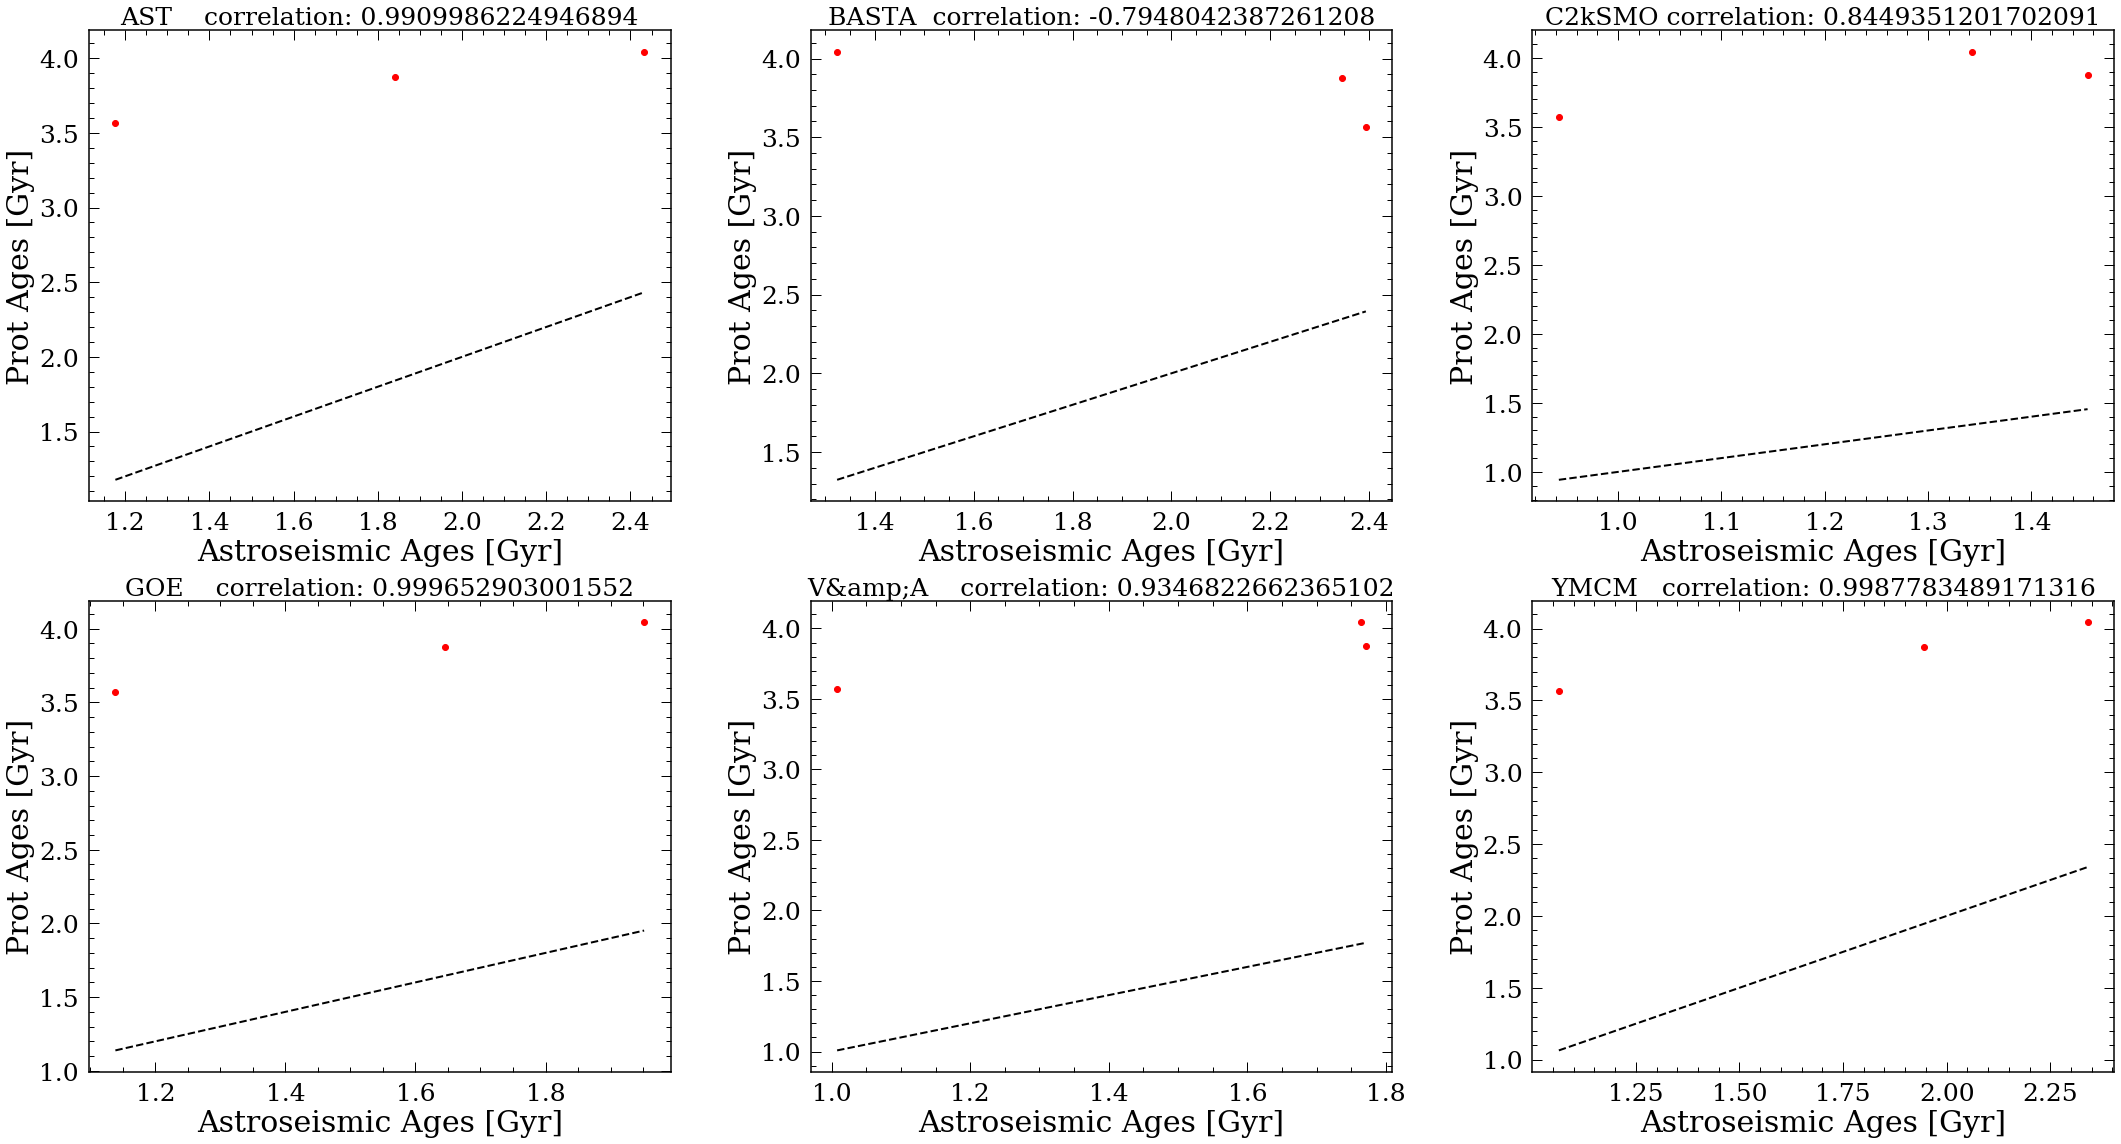

In [140]:
plt.figure(figsize=(30,16))
pcount=1
for pip in Clusters_cm['Pipe'].unique():
    plt.subplot(2,3,pcount)
    plotCM=Clusters_cm.loc[Clusters_cm['Pipe']==pip]
    plt.plot(plotCM["Age"],plotCM["age"],'ro')
    plt.plot([min(plotCM["Age"]),max(plotCM["Age"])],[min(plotCM["Age"]),max(plotCM["Age"])],'k--')
    
    plt.xlabel('Astroseismic Ages [Gyr]')
    #plt.xlim([0,4])
    #plt.ylim([0,4])
    plt.ylabel('Prot Ages [Gyr]')
    r = np.corrcoef(plotCM["Age"], plotCM["age"])
    plt.title(pip+' correlation: '+str(r[1][0]),fontsize=25)
    pcount=pcount+1
plt.tight_layout()
#plt.savefig('checkage.png')

# Abundance trend

In [142]:
with fits.open('APOGEECM_allKepler') as data_ga:
    APOGEE_CM = pd.DataFrame(data_ga[1].data, dtype="float64")
df_st=pd.merge(APOGEE_CM,df,left_on='GAIA_SOURCE_ID',right_on='source_id',how='inner')

df_st=df_st.drop_duplicates(subset='KID')
df_st



,APSTAR_ID,TARGET_ID,ASPCAP_ID,FILE,APOGEE_ID,TELESCOPE,LOCATION_ID,FIELD,J,J_ERR,...,Prot,Prot_log,teff_calc,v_b,Mass,source_id_y,Rvar_log,dv,NoStar,age
0,apogee.apo25m.s.stars.K08_073+19.2M18412508+43...,apo25m.5008.K08_073+19.2M18412508+4303240,apogee.apo25m.s.r12-l33.K08_073+19.2M18412508+...,apStar-r12-2M18412508+4303240.fits,2M18412508+4303240,apo25m,5008.0,K08_073+19,12.652,0.030,...,41.890,1.622110,4117.885214,-32.394829,0.5774,2.116819e+18,3.239367,28.348353,301.0,7.093170
1,apogee.apo25m.s.stars.K08_073+19.2M18430644+42...,apo25m.4409.K08_073+19.2M18430644+4255283,apogee.apo25m.s.r12-l33.K08_073+19.2M18430644+...,apStar-r12-2M18430644+4255283.fits,2M18430644+4255283,apo25m,4409.0,K08_073+19,11.397,0.020,...,13.386,1.126651,4230.108220,0.466957,0.6118,2.116808e+18,4.364537,9.962785,135.0,2.648448
2,apogee.apo25m.s.stars.K08_073+19.2M18430669+43...,apo25m.5008.K08_073+19.2M18430669+4346076,apogee.apo25m.s.r12-l33.K08_073+19.2M18430669+...,apStar-r12-2M18430669+4346076.fits,2M18430669+4346076,apo25m,5008.0,K08_073+19,12.457,0.020,...,16.438,1.215849,5358.856408,21.211602,0.8713,2.116952e+18,4.064414,13.594265,1453.0,3.549363
3,apogee.apo25m.s.stars.K08_073+19.2M18433657+42...,apo25m.5008.K08_073+19.2M18433657+4236306,apogee.apo25m.s.r12-l33.K08_073+19.2M18433657+...,apStar-r12-2M18433657+4236306.fits,2M18433657+4236306,apo25m,5008.0,K08_073+19,10.127,0.023,...,8.202,0.913920,5256.098647,-8.588936,0.8697,2.116748e+18,4.324491,11.470129,622.0,3.024376
4,apogee.apo25m.s.stars.K03_077+20.2M18434242+47...,apo25m.4408.K03_077+20.2M18434242+4756159,apogee.apo25m.s.r12-l33.K03_077+20.2M18434242+...,apStar-r12-2M18434242+4756159.fits,2M18434242+4756159,apo25m,4408.0,K03_077+20,8.167,0.023,...,10.901,1.037466,5988.622220,10.003074,1.0566,2.119828e+18,3.226775,13.668437,356.0,3.567605
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
505,apogee.apo25m.s.stars.K14_080+08.2M20001882+45...,apo25m.4462.K14_080+08.2M20001882+4505134,apogee.apo25m.s.r12-l33.K14_080+08.2M20001882+...,apStar-r12-2M20001882+4505134.fits,2M20001882+4505134,apo25m,4462.0,K14_080+08,11.231,0.019,...,20.708,1.316138,3922.845836,-13.549875,0.4904,2.082166e+18,3.142794,23.047142,33.0,5.836279
506,apogee.apo25m.s.stars.K14_080+08.2M20023362+46...,apo25m.4462.K14_080+08.2M20023362+4600287,apogee.apo25m.s.r12-l33.K14_080+08.2M20023362+...,apStar-r12-2M20023362+4600287.fits,2M20023362+4600287,apo25m,4462.0,K14_080+08,9.846,0.022,...,33.648,1.526959,4362.405526,-8.583655,0.6464,2.085316e+18,3.600573,23.167051,870.0,5.864881
507,apogee.apo25m.s.stars.K14_080+08.2M20035116+45...,apo25m.4462.K14_080+08.2M20035116+4505338,apogee.apo25m.s.r12-l33.K14_080+08.2M20035116+...,apStar-r12-2M20035116+4505338.fits,2M20035116+4505338,apo25m,4462.0,K14_080+08,11.104,0.020,...,11.244,1.050921,4440.311454,-4.842252,0.6686,2.082131e+18,3.915891,12.248266,410.0,3.217299
508,apogee.apo25m.s.stars.K14_080+08.2M20035187+45...,apo25m.4462.K14_080+08.2M20035187+4514124,apogee.apo25m.s.r12-l33.K14_080+08.2M20035187+...,apStar-r12-2M20035187+4514124.fits,2M20035187+4514124,apo25m,4462.0,K14_080+08,10.123,0.020,...,18.438,1.265714,5190.535176,-11.638496,0.8539,2.082138e+18,4.235276,13.978344,1295.0,3.643760


In [147]:
df_st=df_st.loc[abs(df_st['FE_H'])<0.1]
df_st=df_st.loc[abs(df_st['teff_calc']-5778)<=100]
df_st=df_st.loc[abs(df_st['LOGG_1']-4.43)<=0.1]

print(len(df_st))
df_ka=pd.read_table('BedellAbund.csv',delimiter=',')
df_ka.HIP=[int(i) for i in df_ka.HIP.values]
df_ka_age=pd.read_table('Bedell_age.csv',delimiter=',')
df_ka_age.HIP=[int(i) for i in df_ka_age.HIP.values]
df_fe=pd.read_table('Bedell_Fe.csv',delimiter=',')
df_fe.HIP=[int(i) for i in df_fe.HIP.values]

32


In [148]:
df_st_md=pd.merge(df_ka,df_ka_age,left_on='HIP',right_on='HIP',how='inner')
df_st_md=pd.merge(df_st_md,df_fe,left_on='HIP',right_on='HIP',how='inner')
df_st_md.columns

Index(['HIP', '[CI/H]', '[CH/H]', '[OI/H]', '[NaI/H]', '[MgI/H]', '[AlI/H]',
       '[SiI/H]', '[SI/H]', '[CaI/H]', '[ScI/H]', '[ScII/H]', '[TiI/H]',
       '[TiII/H]', '[VI/H]', '[CrI/H]', '[CrII/H]', '[MnI/H]', '[CoI/H]',
       '[NiI/H]', '[CuI/H]', '[ZnI/H]', '_RA', '_DE', 'recno', 'e_[ZnI/H]',
       'e_[VI/H]', 'e_[TiII/H]', 'e_[SiI/H]', 'e_[TiI/H]', 'e_[SI/H]',
       'e_[ScII/H]', 'e_[ScI/H]', 'e_[OI/H]', 'e_[NiI/H]', 'e_[NaI/H]',
       'e_[MnI/H]', 'e_[MgI/H]', 'e_[CuI/H]', 'e_[AlI/H]', 'e_[CaI/H]',
       'e_[CH/H]', 'e_[CI/H]', 'e_[CoI/H]', 'e_[CrI/H]', 'e_[CrII/H]',
       'RAJ2000_x', 'DEJ2000_x', 'Agemp', 'AgeLL1s', 'AgeUL1s', 'AgeLL2s',
       'AgeUL2s', 'Agemean', 'Agestd', 'Massmp', 'MassLL1s', 'MassUL1s',
       'MassLL2s', 'MassUL2s', 'MassMean', 'MassStd', 'RAJ2000_y', 'DEJ2000_y',
       'SNR', 'Teff', 'e_Teff', 'logg', 'e_logg', '[Fe/H]', 'e_[Fe/H]', 'Xi',
       'e_Xi'],
      dtype='object')

In [149]:
abun_apog=['C_FE','MG_FE','AL_FE','SI_FE','S_FE','CA_FE','TI_FE','CR_FE','MN_FE','CO_FE',
       'NI_FE','CU_FE']

abund={'C_FE':'[CI/','MG_FE':'[MgI/','AL_FE':'[AlI/','SI_FE':'[SiI/','S_FE':'[ScI/',
       'CA_FE':'[CaI/','TI_FE':'[TiI/','CR_FE':'[CrI/','MN_FE':'[MnI/','CO_FE':'[CoI/',
       'NI_FE':'[NiI/','CU_FE':'[CuI/'}

Progress: [##################--] 91.7%
27


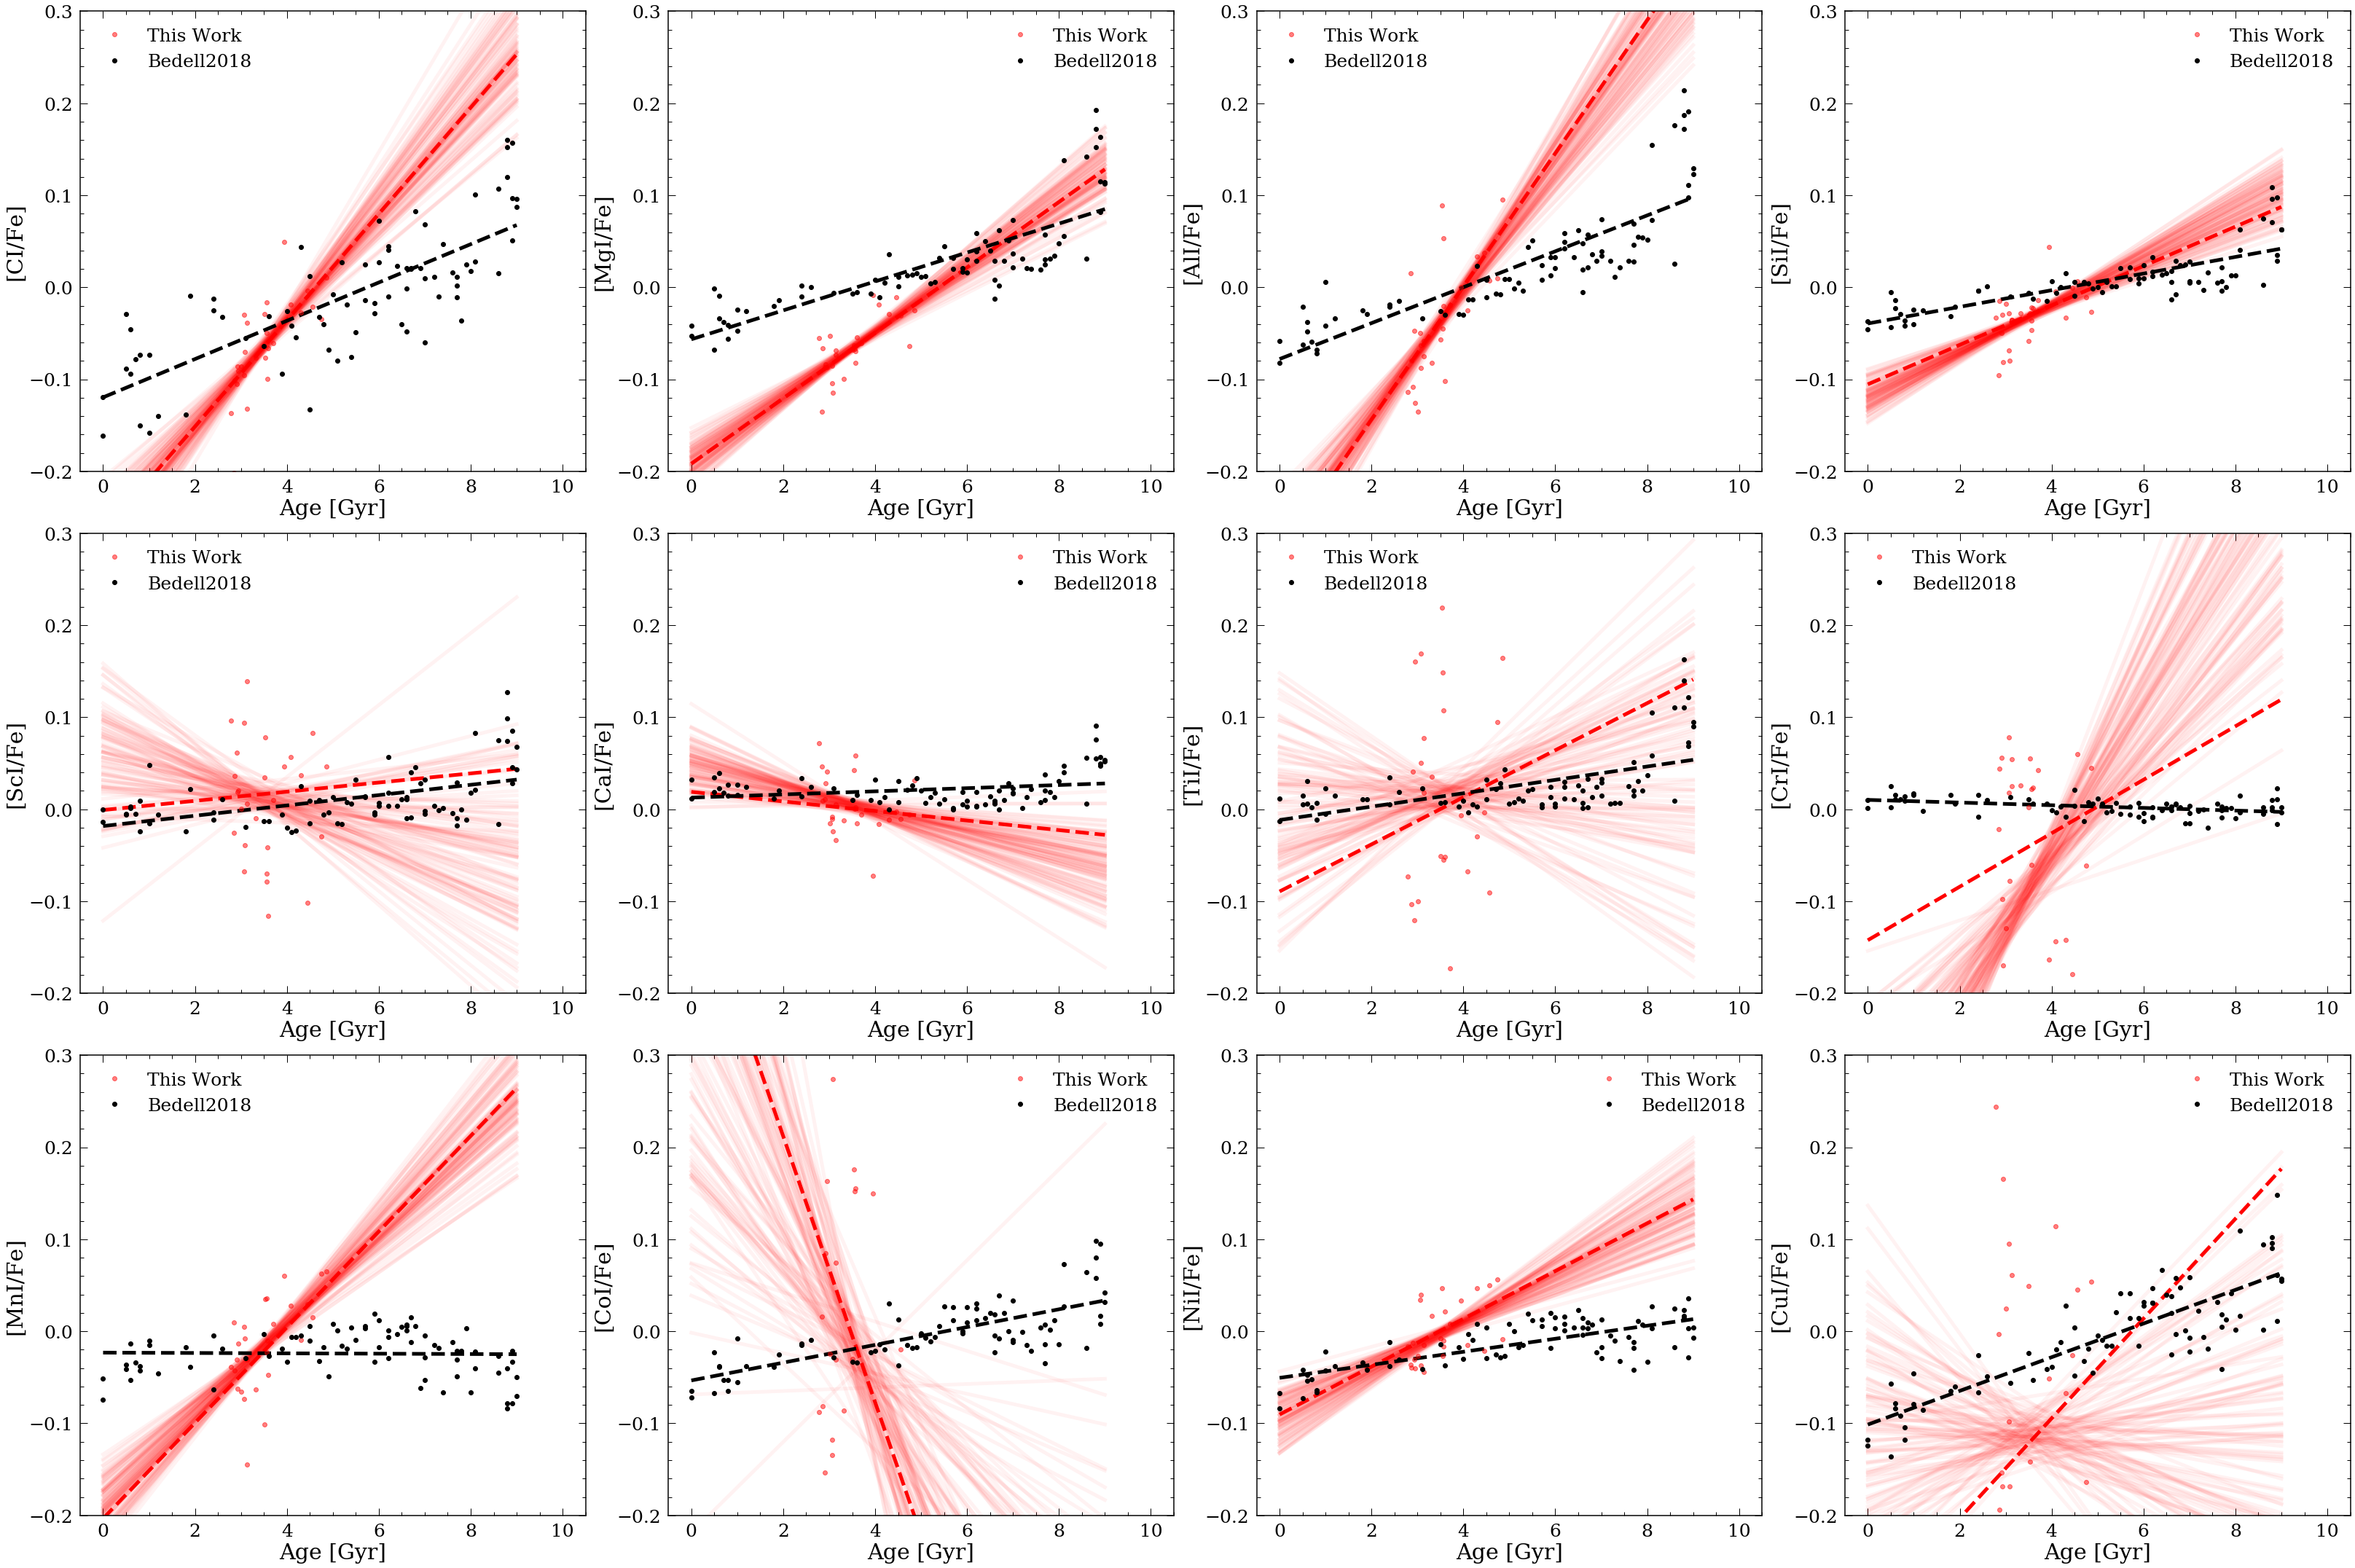

In [162]:
plotv='age'
plt.figure(figsize=(45,30))
for i in range(len(abun_apog)):
    update_progress(i/len(abun_apog))
    df_plot=df_st.loc[df_st[abun_apog[i]]>-100]
    df_plot=df_plot.dropna()
    df_plot=df_plot.reset_index(drop=True)
    
    print(len(df_plot))
    plt.subplot(3,4,i+1)
    
    #err=np.power(df_plot[abun_apog[i]+"_ERR"],2.)+np.power(df_plot["age_STD_err"],2.)
    err=np.power(df_plot[abun_apog[i]+"_ERR"],2.)
    
    """
    plt.errorbar(df_plot[plotv],df_plot[abun_apog[i]],yerr=df_plot[abun_apog[i]+"_ERR"],
                 xerr=df_plot[plotv+'_err'],fmt='ro',label='This Work',alpha=0.5)
    """
    #plt.errorbar(df_plot[plotv],df_plot[abun_apog[i]],yerr=df_plot[abun_apog[i]+"_ERR"],fmt='ro',label='This Work',alpha=0.5)
    plt.errorbar(df_plot[plotv],df_plot[abun_apog[i]],fmt='ro',label='This Work',alpha=0.5)
    
    z = np.polyfit(df_plot[plotv],df_plot[abun_apog[i]],1,w=1./np.power(df_plot[abun_apog[i]+'_ERR'],2))
    p = np.poly1d(z)
    plt.plot(range(10),p(range(10)),'r--',linewidth=5)
        
    for k in range(100):
        new_age_mock=df_plot[plotv]
        new_abun_mock=np.array([np.random.normal(df_plot.iloc[j][abun_apog[i]], 
                        df_plot.iloc[j][abun_apog[i]+"_ERR"]) for j in range(len(df_plot))])
        z = np.polyfit(new_age_mock,new_abun_mock,1)
        p = np.poly1d(z)
        plt.plot(range(10),p(range(10)),'r-',linewidth=5,alpha=0.05)
    
    z = np.polyfit(df_st_md['Agemp'], df_st_md[abund[abun_apog[i]]+'H]']-df_st_md['[Fe/H]'],1)
    p = np.poly1d(z)
    
    plt.errorbar(df_st_md['Agemp'],df_st_md[abund[abun_apog[i]]+'H]']-df_st_md['[Fe/H]'],
                 fmt='ko',label='Bedell2018')
    plt.plot(range(10),p(range(10)),'k--',linewidth=5)
    
    
    plt.ylim([-0.2,0.3])
    plt.xlim([-0.5,10.5])
    plt.ylabel(abund[abun_apog[i]]+'Fe]')
    plt.xlabel('Age [Gyr]')
    plt.legend()
plt.tight_layout()
plt.savefig('Abundances_RvarProt.png')
    
    